## Visualizing effect of prior on posterior using trace plots and rank plots
author: @karm-patel


Please find numpyro implementation of this notebook here:https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book2/11/mcmc_traceplots_unigauss_numpyro.ipynb

In [1]:
import jax.numpy as jnp
import jax
import os

try:
    import blackjax
except ModuleNotFoundError:
    %pip install -qq blackjax
    import blackjax

try:
    import tensorflow_probability.substrates.jax as tfp
except:
    %pip install tensorflow_probability
    import tensorflow_probability.substrates.jax as tfp

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

try:
    import arviz as az
except ModuleNotFoundError:
    %pip install -qq arviz
    import arviz as az

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

In [2]:
prior_alpha = tfp.distributions.Normal(0, 1000)
prior_sigma = tfp.distributions.Exponential(0.0001)
y = jnp.array([-1, 1])

In [3]:
n_chains = 3
initial_positions = {
    "alpha": prior_alpha.sample(n_chains, seed=jax.random.PRNGKey(2)),
    "sigma": prior_sigma.sample(n_chains, seed=jax.random.PRNGKey(4)),
}

In [4]:
def inference_loop_multiple_chains(rng_key, kernel, initial_states, num_samples, num_chains):
    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, info = jax.vmap(kernel)(keys, states)

        return states, {"states": states, "info": info}

    keys = jax.random.split(rng_key, num_samples)
    _, states_and_info = jax.lax.scan(one_step, initial_states, keys)

    return states_and_info

In [5]:
def create_trace_from_states(states, info, burn_in=0):
    """
    input: states & info which is returned by blackjax
    output: make trace which can be directly passed to arviz
    """
    samples = {}
    for param in states.position.keys():
        ndims = len(states.position[param].shape)
        if ndims == 2:
            samples[param] = jnp.swapaxes(states.position[param], 0, 1)[:, burn_in:]  # swap n_samples and n_chains
            divergence = jnp.swapaxes(info.is_divergent[burn_in:], 0, 1)

        if ndims == 1:
            divergence = info.is_divergent
            samples[param] = states.position[param]
    trace_posterior = az.convert_to_inference_data(samples)
    trace_sample_stats = az.convert_to_inference_data({"diverging": divergence}, group="sample_stats")
    trace = az.concat(trace_posterior, trace_sample_stats)
    return trace, samples

## Diffuse prior

In [6]:
def log_joint_prob_bad_prior(params, obs_data=y):
    alpha, sigma = params["alpha"], params["sigma"]
    # prior
    log_prob_alpha = tfp.distributions.Normal(0, 1000).log_prob(alpha)
    log_prob_sigma = tfp.distributions.Exponential(0.0001).log_prob(sigma)
    log_prior = log_prob_alpha + log_prob_sigma

    # likelihood
    log_likelihood = tfp.distributions.Normal(loc=alpha, scale=sigma).log_prob(obs_data).sum()

    return log_prior + log_likelihood

In [7]:
inv_mass_matrix = jnp.array([1, 1])
step_size = 0.3
model = blackjax.nuts(log_joint_prob_bad_prior, step_size, inv_mass_matrix)

In [8]:
initial_states = jax.vmap(model.init)(initial_positions)
initial_states

HMCState(position={'alpha': DeviceArray([ 428.515  , 1077.8004 ,  163.13783], dtype=float32), 'sigma': DeviceArray([4982.097  ,  139.92233, 3284.2356 ], dtype=float32)}, potential_energy=DeviceArray([36.499542, 88.68582 , 35.412888], dtype=float32), potential_energy_grad={'alpha': DeviceArray([0.00046304, 0.11117956, 0.00019339], dtype=float32), 'sigma': DeviceArray([ 4.9846753e-04, -8.3370405e-01,  7.0746709e-04], dtype=float32)})

In [9]:
# sanity check
jax.vmap(log_joint_prob_bad_prior)(initial_positions)

DeviceArray([-36.499542, -88.68582 , -35.412888], dtype=float32)

In [10]:
%%time
kernel = jax.jit(model.step)
states_and_info = inference_loop_multiple_chains(jax.random.PRNGKey(1), kernel, initial_states, 1000, n_chains)
states, info = states_and_info["states"], states_and_info["info"]

CPU times: user 4.79 s, sys: 66.1 ms, total: 4.86 s
Wall time: 4.81 s


In [11]:
print(f"Number of divergences (bad prior) = {info.is_divergent[500:,:].sum()}")

Number of divergences (bad prior) = 16


In [12]:
trace_bad, samples_bad = create_trace_from_states(states, info, burn_in=500)
az.summary(trace_bad)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,34.376,159.313,-189.103,475.574,25.464,18.142,115.0,38.0,1.08
sigma,166.214,309.793,0.585,825.557,62.506,44.734,22.0,58.0,1.11


In [13]:
print(
    f"alpha:{trace_bad.posterior.alpha.shape}\nsigma:{trace_bad.posterior.sigma.shape}\ndivergence:{trace_bad.sample_stats.diverging.shape}"
)

alpha:(3, 500)
sigma:(3, 500)
divergence:(3, 500)


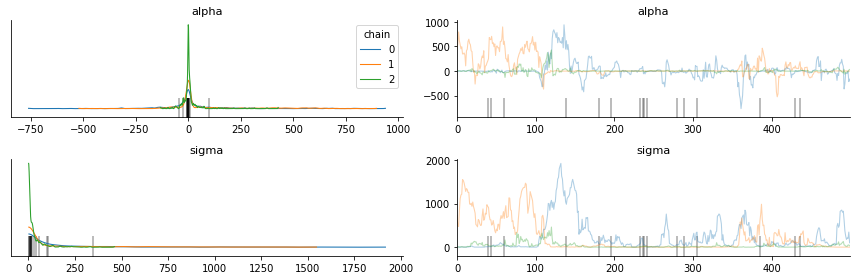

In [14]:
axs = az.plot_trace(trace_bad, compact=False, legend=True, divergences=True)
sns.despine()
plt.tight_layout()

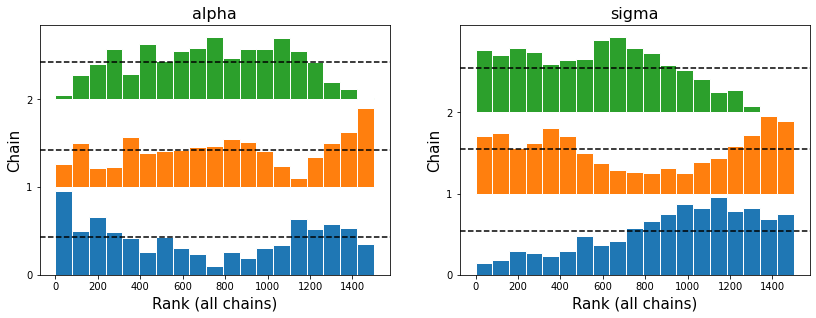

In [15]:
az.plot_rank(trace_bad);

## Senseble prior

In [16]:
def log_joint_prob_good_prior(params, obs_data=y):
    alpha, sigma = params["alpha"], params["sigma"]
    # prior
    log_prob_alpha = tfp.distributions.Normal(1, 10).log_prob(alpha)
    log_prob_sigma = tfp.distributions.Exponential(1).log_prob(sigma)
    log_prior = log_prob_alpha + log_prob_sigma

    # likelihood
    log_likelihood = tfp.distributions.Normal(loc=alpha, scale=sigma).log_prob(obs_data).sum()

    return log_prior + log_likelihood

In [17]:
inv_mass_matrix = jnp.array([1, 1])
step_size = 0.05

model = blackjax.nuts(log_joint_prob_good_prior, step_size, inv_mass_matrix)

In [18]:
initial_states = jax.vmap(model.init)(initial_positions)
initial_states

HMCState(position={'alpha': DeviceArray([ 428.515  , 1077.8004 ,  163.13783], dtype=float32), 'sigma': DeviceArray([4982.097  ,  139.92233, 3284.2356 ], dtype=float32)}, potential_energy=DeviceArray([5918.0366, 6011.6943, 3436.9346], dtype=float32), potential_energy_grad={'alpha': DeviceArray([ 4.2751846, 10.878106 ,  1.6214086], dtype=float32), 'sigma': DeviceArray([1.0003985 , 0.16619593, 1.0006075 ], dtype=float32)})

In [19]:
# sanity check
jax.vmap(log_joint_prob_good_prior)(initial_positions)

DeviceArray([-5918.0366, -6011.6943, -3436.9346], dtype=float32)

In [20]:
%%time
kernel = jax.jit(model.step)
states_and_info = inference_loop_multiple_chains(jax.random.PRNGKey(1), kernel, initial_states, 1000, n_chains)
states, info = states_and_info["states"], states_and_info["info"]

CPU times: user 3.57 s, sys: 39.5 ms, total: 3.61 s
Wall time: 3.56 s


In [21]:
print(f"Number of divergences (good prior) = {info.is_divergent[500:,:].sum()}")

Number of divergences (good prior) = 0


In [22]:
trace_good, samples_good = create_trace_from_states(states, info, burn_in=500)
az.summary(trace_good)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.004,1.231,-2.540,2.334,0.082,0.067,277.0,211.0,1.01
sigma,1.485,0.751,0.492,2.834,0.050,0.036,296.0,383.0,1.00


In [23]:
print(
    f"alpha:{trace_good.posterior.alpha.shape}\nsigma:{trace_good.posterior.sigma.shape}\ndivergence:{trace_good.sample_stats.diverging.shape}"
)

alpha:(3, 500)
sigma:(3, 500)
divergence:(3, 500)


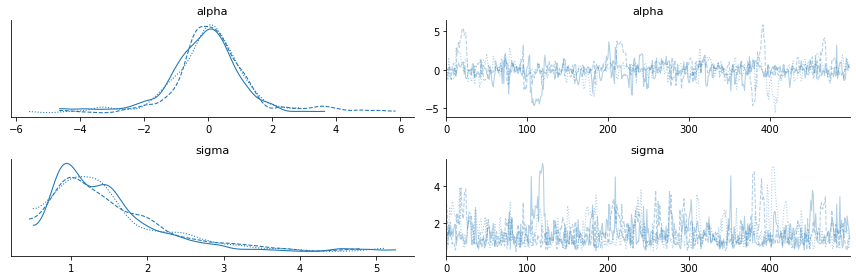

In [24]:
az.plot_trace(trace_good)
plt.tight_layout()
sns.despine()

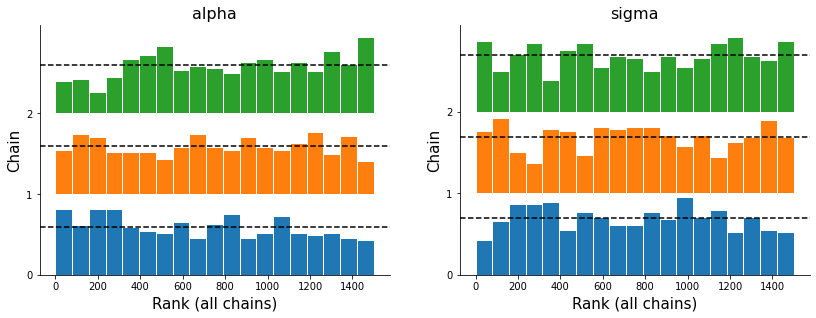

In [25]:
az.plot_rank(trace_good)
sns.despine();

## Latexified Figures

In [26]:
# os.environ["LATEXIFY"] = ""
# os.environ["FIG_DIR"] = "figures"
# os.environ.pop("LATEXIFY")

In [27]:
def plot_trace(trace, fig_name=None):
    pml.latexify(width_scale_factor=1, fig_height=2)
    fig, axes = plt.subplots(2, 2)
    axs = az.plot_trace(
        trace,
        compact=False,
        divergences=True,
        axes=axes,
        plot_kwargs={"lw": 0.8},
        trace_kwargs={"lw": 0.8, "alpha": 0.8},
    )
    axes = axes.flatten()

    # set divergence vertical lines height and width
    scale = 0.001
    for ax in axes:
        lines = ax.get_lines()
        if len(lines) == 3:
            continue
        for line in lines[3:]:
            line.set_markeredgewidth(1)
            line.set_markersize(10)
            line.set_alpha(0.8)

    # set legend
    leg_ax = axes[2]
    l = leg_ax.get_lines()
    leg_ax.legend(handles=l, labels=["chain1", "chain2", "chain3"], fontsize=8, framealpha=0.5)

    # set title
    axes[0].set_title("alpha")
    axes[1].set_title("alpha")
    axes[2].set_title("sigma")
    axes[3].set_title("sigma")

    sns.despine()
    # plt.tight_layout()
    if fig_name:
        pml.savefig(fig_name)

/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")
/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


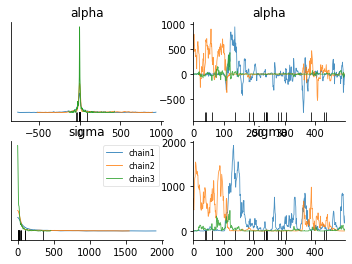

In [28]:
plot_trace(trace_bad, "mcmc_traceplot_unigauss_bad")

/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")
/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


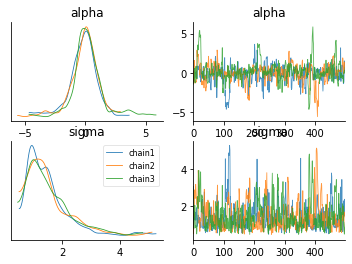

In [29]:
plot_trace(trace_good, "mcmc_traceplot_unigauss_good")

In [30]:
def plot_rank(trace, fig_name=None):
    pml.latexify(width_scale_factor=1, fig_height=2)
    fig, axes = plt.subplots(1, 2)
    az.plot_rank(trace, ax=axes)
    sns.despine()
    if fig_name:
        pml.savefig(fig_name)

/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


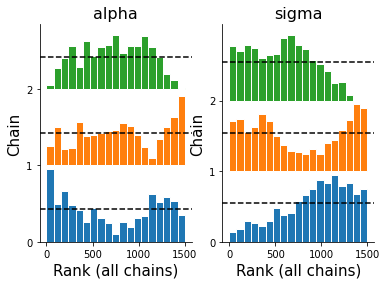

In [31]:
plot_rank(trace_bad, "mcmc_trankplot_unigauss_bad")

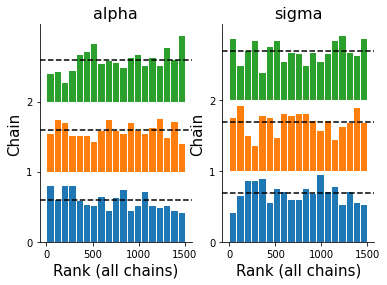

In [32]:
plot_rank(trace_good, "mcmc_trankplot_unigauss_good")